# Example of *AIS* post-processing functions

This notebook shows examples on what you can do with the post-processing module of *AIS* package.

In [1]:
# We need to import these packages
import sys
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# The *AIS* Python packages can be found under the parent directory of the current notebook
sys.path.append('../')

In [3]:
# Import the post-procesing module
from modules import postprocessing_functions as post

## Set up the general conversion function to e- for a particular camera

For all the other functions to work, we need to form the conversion function that takes the image brightness values and converts them into e- charges at the detector pixel.

The following parameters need to be set:

In [4]:
detectorResolution              =  [640, 512]
FoV                             =  [0.116937, 0.0942478]
distanceToSun                   =  1.0 # au
apertureDiameter                =  13.6 # mm
opticsTransmission              =  0.9
spectralTransmissionStrength    =  0.3 # Constant transmission factor through the window
spectralTransmissionWindowWidth =  25 # The width of the transmission windon, in nanometers. Must be an integer
extraWL = int(np.ceil(spectralTransmissionWindowWidth/2)) # Can be just computed, additional wl to counteract the edge effects in spectral transmission convolution later
wlStart                         =  700-extraWL # The starting wavelength for the spectrometer, nm
wlEnd                           =  1800+extraWL # The ending wavelength for the spectrometer, nm
targetSpectra                   =  "../modules/data/S-type-asteroid-spectra.txt" # Spectra of the target in a file
# Note, for flat target spectra, set:
#targetSpectra                  =  None
qeDataName                      =  "../modules/data/ASPECT-NIR-quantum-efficiency.txt" # The quantum efficiency of the detector in a file

Code to run.

In [5]:
verbose = True
wlArray = np.arange(wlStart+extraWL, wlEnd-extraWL, 1) # Range for 'good' wavelengths

# Conversion from image values to radiant flux
convFact1 = post.toRadiantFlux(au=distanceToSun, FoV=FoV, apertureDiameter=apertureDiameter, \
                        detectorResolution=detectorResolution, opticsTransmission=opticsTransmission, verbose=verbose)
print("---")

# Build 'flatConvFunc' for spectral SNR analysis
[wla, convFact20] = post.toSpectralFlux(convFact1, wlStart, wlEnd, targetSpectra=None)
convFact30 = post.toSpectralTransmission(convFact20, spectralTransmissionStrength, spectralTransmissionWindowWidth)
flatConvFunc = post.toQEMonoFunction(convFact30, wla, qeDataName)

# Interpolation function for target's spectra
targetSpectraInterp = post.readTargetSpectra(targetSpectra, verbose=verbose)
print("---")

# Conversion from radiant flux to spectral flux
[wla, convFact2] = post.toSpectralFlux(convFact1, wlStart, wlEnd, targetSpectra=targetSpectraInterp, verbose=verbose)
print("---")

# Conversion from spectral flux to spectral transmission after the spectral filter
convFact3 = post.toSpectralTransmission(convFact2, spectralTransmissionStrength, spectralTransmissionWindowWidth, verbose=verbose)
print("---")

# Final conversion from spctral transmission to e- charges at the detector pixel level
finalConvFunc = post.toQEMonoFunction(convFact3, wla, qeDataName, verbose=verbose)

Computing conversion factor to radiant flux units at camera pixel for an radiance factor value of 1.
*Radiance at 1.0 au is 217.0 W/m^2
*Radiant flux received by camera pixel when the camera FoV is [0.116937, 0.0942478] and the detector resolution is [640, 512] is 1.0642301087086547e-09 W.
*After optics transmission factor of 0.9 the radiant flux is 9.578070978377893e-10 W.
---
*Target spectra read from file '../modules/data/S-type-asteroid-spectra.txt'
---
Computing the spectral distribution of radiant flux at detector pixel.
*Flux distributed to 1127 spectral channels from 687 to 1813. Spectral flux at 687 is 1.1903204282606569e-12 W and at 1813 it is 1.5675364269034695e-13 W
---
Computing the spectral flux after the spectral filter transmission function.
---
Converting spectral flux into qe charges at the detector.
*Detector quantum efficiency read from file '../modules/data/ASPECT-NIR-quantum-efficiency.txt'.
*Quantum efficiency data range is [ 700. 1800.].


Possible analysis of the results.

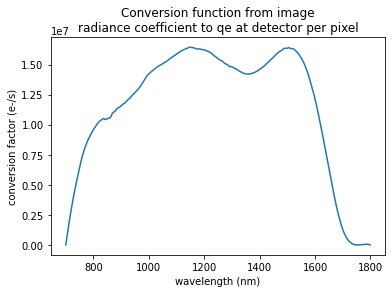

In [6]:
y = finalConvFunc(wlArray)
plt.plot(wlArray,y)
plt.title("Conversion function from image\nradiance coefficient to qe at detector per pixel")
plt.xlabel("wavelength (nm)");
plt.ylabel("conversion factor (e-/s)");
plt.show()

## SNR analysis for the camera

Analyze the signal-to-noise ratio (SNR) of the camera unit.

The following parameters are needed:

In [7]:
readNoise         =  15 # read noise, e-
darkCurrent       =  1.0 # dark current in femtoamperes per millisecond
integrationTime   =  20 # exposure time in milliseconds
fullWellCapacity  =  15000 # in e-
surfaceAlbedo     =  0.04 # The normal albedo of a surface element to be analyzed
snrWl             =  800 # Wavelength where SNR analysis for albedo and integration time are done

Compute.

In [8]:
verbose = True
# Compute SNR as a function of wavelength
snrSpec = post.computeSNR(surfaceAlbedo, finalConvFunc, wlArray, readNoise, darkCurrent, integrationTime, \
                      fullWellCapacity, verbose=verbose)
print("---")

# Compute SNR as a function of albedo
albArr = np.arange(0,0.21,0.01)
snrAlb = post.computeSNR(albArr, finalConvFunc, snrWl, readNoise, darkCurrent, integrationTime, \
                      fullWellCapacity, verbose=verbose)
print("---")

# Compute SNR as a function of integration time
itArr = np.arange(0,101,1)
snrIt = post.computeSNR(surfaceAlbedo, finalConvFunc, snrWl, readNoise, darkCurrent, itArr, \
                      fullWellCapacity, verbose=verbose)

Computing SNR.
*Single radiance coefficient.
*List of wavelengths.
*Maximum signal is 13148.80365204998, Poisson noise component for that 114.66823296820257, read noise component 15, dark current component 11.17274279168796.
---
Computing SNR.
*List of radiance coefficient values.
*Single wavelength.
Warning, detector is saturated
*Maximum signal is 15000.0, Poisson noise component for that 122.47448713915891, read noise component 15, dark current component 11.17274279168796.
---
Computing SNR.
*Single radiance coefficient.
*Single wavelength.
Warning, detector is saturated
*Signal is [    0.           383.32511983   766.65023967  1149.9753595
  1533.30047933  1916.62559917  2299.950719    2683.27583883
  3066.60095866  3449.9260785   3833.25119833  4216.57631816
  4599.901438    4983.22655783  5366.55167766  5749.8767975
  6133.20191733  6516.52703716  6899.852157    7283.17727683
  7666.50239666  8049.8275165   8433.15263633  8816.47775616
  9199.80287599  9583.12799583  9966.4531156

Output, SNR as a function of wavelength.

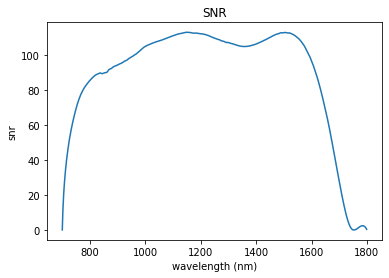

In [9]:
plt.plot(wlArray,snrSpec)
plt.title("SNR")
plt.xlabel("wavelength (nm)");
plt.ylabel("snr");
plt.show()

Output, SNR as a function of surface albedo.

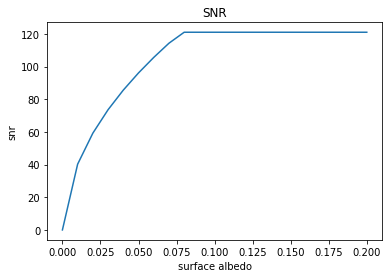

In [10]:
plt.plot(albArr,snrAlb)
plt.title("SNR")
plt.xlabel("surface albedo");
plt.ylabel("snr");
plt.show()

Output, SNR as a function of integration time.

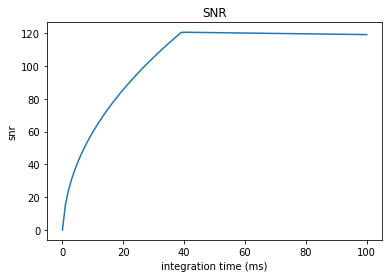

In [11]:
plt.plot(itArr,snrIt)
plt.title("SNR")
plt.xlabel("integration time (ms)");
plt.ylabel("snr");
plt.show()

## Spectral retrieval analysis for the camera

Analyze how the spectral retrieval of the target would look like with this camera and noise parameters.

Parameters needed:

In [12]:
readNoise         =  15 # read noise e-
darkCurrent       =  1.0 # dark current in femtoamperes per millisecond
integrationTime   =  20 # exposure time in milliseconds
fullWellCapacity  =  15000 # in e-
surfaceAlbedo     =  0.04 # Normal albedo of the surface 
# Spectra retrieved at these wavelengths.
wlSample          =  [800, 900, 950, 1000, 1050, 1200, 1200, 1300, 1400, 1500, 1700]

Run the computations.

In [25]:
# Build noisless spectra
origSpectra = [targetSpectraInterp(w) for w in wlArray]
# Simulate the noisless retrieved spectral flux
flatFlux = post.simulateNoiseless(surfaceAlbedo, flatConvFunc, wlSample, darkCurrent, integrationTime)

# Simulate retrieved spectral flux
reflectedFlux = post.simulateNoise(surfaceAlbedo, finalConvFunc, wlSample, readNoise, darkCurrent, integrationTime, fullWellCapacity)

# Retrieved spectra
noisySpectra = reflectedFlux/flatFlux

Output, noisless spectra and one realization of retrieved spectral values.

In [26]:
plt.plot(wlArray,origSpectra)
plt.plot(wlSample,noisySpectra, 'ro', linestyle='None')

## Image SNR analysis

Analyze how a perect image would change with realistic noise from the detector.

Parameters needed:

In [27]:
imageFileName     =  "frame-1.png" # Name of the image file to be analyzed
imageFolder       =   "../Renders/test/Original/" # Folder where the image is
imageAlbedo       =  0.4 # The 'imageAlbedo' value used when rendering the image
surfaceAlbedo     =  0.04 # The actual normal albedo of the target's surface
snrWl             =  800 # Wavelength where SNR analysis for albedo and integration time are done
readNoise         =  15 # read noise e-
darkCurrent       =  1.0 # dark current in femtoamperes per millisecond
integrationTime   =  1 # exposure time in milliseconds
fullWellCapacity  =  15000 # in e-

Code to run.

In [28]:
verbose = True
# Import noisless image
[origIm, imH, maxRc] = post.importImageData(imageFileName, foldername=imageFolder, \
                                imageAlbedo=imageAlbedo, targetAlbedo=surfaceAlbedo, verbose=verbose)

# Simulate noise to the image
noisyIm = post.simulateNoise(origIm, finalConvFunc, snrWl, readNoise, darkCurrent, integrationTime, fullWellCapacity)

# Find suitable maximum brightness value for shared color map.
imNormVal = finalConvFunc(snrWl) * 1.1*maxRc * integrationTime * 10e-4

Importing an image and converting the RGB-values to radiance coefficient scale.
*Read image from file 'frame-1.png'. Bit depth is 16, image resolution (512, 512).
*Image grayscale value range is [0.0, 0.7079270618753338].
*Image radiance coefficient value range is [0.0, 0.07079270618753337].


Output, original image.

In [29]:
fig = plt.figure()
sizew = 8
fig.set_size_inches((sizew,sizew))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(origIm.reshape(imH,-1), cmap="gray", norm=None, vmin=0, vmax=1.1*maxRc)

Output, noisy image.

In [30]:
fig = plt.figure()
sizew = 8
fig.set_size_inches((sizew,sizew))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(noisyIm.reshape(imH,-1), cmap="gray", norm=None, vmin=0, vmax=imNormVal)

## Image conversion and export to hyperspectral data cube

Build a hyperspectral datacube out from one perfect image and the target spectra, and export as PNG image stack.

Parameters needed:

In [31]:
imageFileName      =  "frame-1.png"
imageFolder        =   "../Renders/test/Original/"
outputPNGBaseName  =  "hs"
outputFolder       =  "../Renders/test/Post-processed/"
imageAlbedo        =  0.4
surfaceAlbedo      =  0.04
readNoise          =  15 # read noise e-
darkCurrent        =  1.0 # dark current in femtoamperes per millisecond
integrationTime    =  10 # exposure time in milliseconds
fullWellCapacity   =  15000 # in e-
# Hyperspectral datacube built at these wavelengths.
wlSample           =  [800, 1200, 1700]

Code to run:

In [32]:
verbose = True
# Import noisless image
[origIm, imH, maxRc] = post.importImageData(imageFileName, foldername=imageFolder, \
                                imageAlbedo=imageAlbedo, targetAlbedo=surfaceAlbedo, verbose=verbose)

# Build spectral datacube and simulate noise 
hsData = post.simulateNoise(origIm, finalConvFunc, wlSample, readNoise, darkCurrent, integrationTime, fullWellCapacity)

Importing an image and converting the RGB-values to radiance coefficient scale.
*Read image from file 'frame-1.png'. Bit depth is 16, image resolution (512, 512).
*Image grayscale value range is [0.0, 0.7079270618753338].
*Image radiance coefficient value range is [0.0, 0.07079270618753337].


Output the PNG image stack.

In [36]:
post.exportHsPNG(hsData, imH, outputPNGBaseName, outputFolder)